In [4]:
import xarray as xr
from merge_daily_data import load_config, cut_file
import os
import pandas as pd
import time
import geopandas as gpd
from shapely.geometry import Polygon, mapping
from SPI_wet_dry import spiObject

CONFIG_PATH = r"../config.yaml"
config = load_config(CONFIG_PATH)

In [4]:
import eumdac
consumer_key = config['DEFAULT']['key']
consumer_secret = config['DEFAULT']['secret']
credentials = (consumer_key, consumer_secret)
token = eumdac.AccessToken(credentials)
print(f"This token '{token}' expires {token.expiration}")
datatailor = eumdac.DataTailor(token)
#datatailor.collections
natural_color_disc = datatailor.chains.read('natural_color_disc')

This token 'eaf8825b-2d5d-35b3-a32f-e0fdca3ec086' expires 2022-11-02 13:28:02.521173


In [5]:
natural_color_disc

Chain(id='natural_color_disc', product='HRSEVIRI', format='geotiff', name='Natural color disc', description=None, aggregation=None, projection=None, roi=None, filter='hrseviri_natural_color', quicklook=None, resample_method=None, resample_resolution=None, compression=None)

In [2]:

path_spi = config['SPI']['CHIRPS']['path']
countries = ['Ethiopia','Somalia','Kenya']
aggr = 'season'
file_path = (os.path.join(path_spi, 'CHIRPS_spi_gamma_30.nc'))
spi = spiObject(file_path)
shapefile_path = os.path.join('..',config['SHAPE']['africa'])
aggregation = 'time.{}'.format(aggr)
#### Chose subset of countries
gdf = gpd.read_file(shapefile_path)
subset = gdf[gdf.ADM0_NAME.isin(countries)]
###open file and cut it
spi.xr = cut_file(xr.open_dataset(file_path, chunks={"lat": -1, "lon": -1, "time": 12}), subset)

res_xr = cut_file(spi.calculate_points_xr(), subset)



for year in range(2009,2010):
        season_xr = res_xr.sel(time=slice('{}-01-01'.format(year), '{}-12-31'.format(year)))\
        .groupby(aggregation).mean(dim="time")

for country in countries[0]:
        # get the start time
    st = time.time()
    for i, season in enumerate(("DJF", "MAM", "JJA", "SON")):
        mean_dry = season_xr["dry"].sel(season=season).mean(['lon','lat']).values
        mean_wet = season_xr["wet"].sel(season=season).mean(['lon','lat']).values

Computed new variables for xarray


(array([1.1494e+04, 3.9400e+02, 1.7200e+02, 6.9000e+01, 5.8000e+01,
        1.9000e+01, 2.6000e+01, 1.7000e+01, 8.0000e+00, 1.9000e+01]),
 array([0.        , 0.03296703, 0.06593407, 0.0989011 , 0.13186813,
        0.16483516, 0.1978022 , 0.23076923, 0.26373626, 0.2967033 ,
        0.32967033]),
 <BarContainer object of 10 artists>)

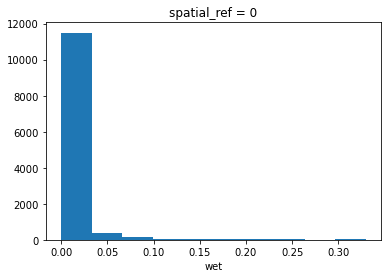

In [3]:
season_xr['wet'].plot()

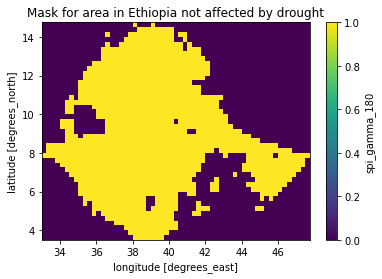

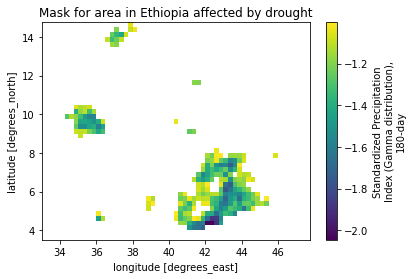

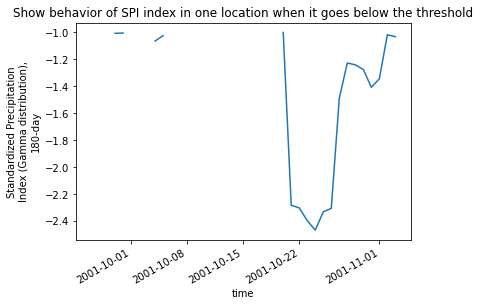

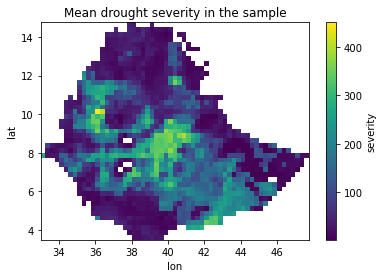

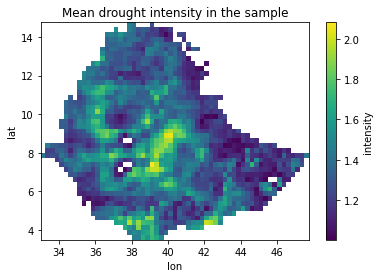

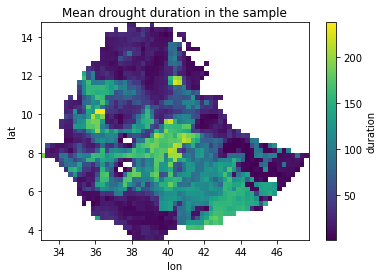

14.838082551956177


In [1]:
from dataclasses import dataclass
import matplotlib.pyplot as plt
from SPI_wet_dry import spiObject
import numpy as np
import xarray as xr
from merge_daily_data import load_config, cut_file
import os
import pandas as pd
import time
import geopandas as gpd
from shapely.geometry import Polygon, mapping
from SPI_wet_dry import spiObject
import time

start = time.time()

CONFIG_PATH = r"../config.yaml"
config = load_config(CONFIG_PATH)

product_dir = config['SPI']['CHIRPS']['path']
files  = [f for f in os.listdir(product_dir) if f.endswith('.nc')]
path_spi = os.path.join(product_dir, files[0])
spi = spiObject(path_spi)
shapefile_path = os.path.join('..', config['SHAPE']['africa'])
#### Chose subset of countries
gdf = gpd.read_file(shapefile_path)
subset = gdf[gdf.ADM0_NAME.isin(['Ethiopia'])]
###open file and cut it
with xr.open_dataset(path_spi, chunks={"lat": -1, "lon": -1, "time": 12}) as data:
    res_xr = cut_file(data, subset)

####drop all the values after 180 days
time_thresh = res_xr['time'].isel(time=180).values
threshold = -1
ds = res_xr.where(res_xr.time > time_thresh, drop=True)
#### slice by one year only
ds = ds.sel(
    time=slice('2001-01-01', '2003-01-01'))

ds = ds.load()

#### create masks for null and for drought-non drought 
null_mask = ds.where(ds['spi_gamma_180'].notnull(), 0)
masked = xr.where(ds['spi_gamma_180']>= threshold, 1, 0)
#masked = ds.where(ds['spi_gamma_180']<= threshold, )
masked.isel(time=200).plot()
plt.title('Mask for area in Ethiopia not affected by drought')
plt.show()

ds = ds.assign(masked = masked)
new_xr = ds.assign(index = ds['masked'].cumsum(['time']))
new_xr['spi_gamma_180'].where(new_xr.masked ==0).isel(time=200).plot()
plt.title('Mask for area in Ethiopia affected by drought')
plt.show()

new_xr.where(new_xr.masked==0).sel(lat= 3.625, lon=38.375, method='nearest')['spi_gamma_180'].plot() #.where(null_mask['spi_gamma_180']!=0)
plt.title('Show behavior of SPI index in one location when it goes below the threshold')
plt.show()
import datetime as dt
#new_xr = new_xr.assign(year = new_xr['time'].dt.year, season= new_xr['time'].dt.month%12 // 3 + 1)

df= new_xr.where(new_xr.masked==0).to_dataframe().dropna(subset=['index','spi_gamma_180']).drop(columns={'spatial_ref'}) #.where(null_mask['spi_gamma_180']!=0)
duration_df = df.groupby(["lat", "lon",'index']).count().drop(columns={'spi_gamma_180'}).rename(columns={'masked':'duration'})
severity_df = df.groupby(["lat", "lon",'index']).sum().drop(columns={'masked'}).rename(columns={'spi_gamma_180':'severity'})
severity_df['severity'] = abs(severity_df['severity'])
res_df = severity_df.merge(duration_df, left_index=True, right_index=True)
res_df['intensity']= res_df['severity']/res_df['duration']

run_xr = new_xr.to_dataframe().reset_index().merge(res_df.reset_index(), on=['lat','lon','index'], how='left')\
    .drop(columns={'spatial_ref'}).set_index(['lat','lon','time']).to_xarray()

events_df = new_xr.to_dataframe().reset_index().merge(res_df.reset_index(), on=['lat','lon','index'], how='left')\
    .drop(columns={'spatial_ref','masked','spi_gamma_180'}).dropna(subset=['severity','duration','intensity'])\
        .drop_duplicates(subset=['lat','lon','index','severity','duration','intensity'], keep='first').drop(columns={'index'})

events_df['year'] = events_df['time'].dt.year
events_df['month'] = events_df['time'].dt.month

run_xr['severity'].mean(['time']).plot()
plt.title('Mean drought severity in the sample')
plt.show()
run_xr['intensity'].mean(['time']).plot()
plt.title('Mean drought intensity in the sample')
plt.show()
run_xr['duration'].mean(['time']).plot()
plt.title('Mean drought duration in the sample')
plt.show()

end = time.time()
print(end - start)

In [2]:
from datetime import datetime 

new_df = new_xr.to_dataframe().reset_index().merge(res_df.reset_index(), on=['lat','lon','index'], how='left')\
    .drop(columns={'spatial_ref'})

new_df['year'] = new_df.time.dt.year
new_df['month'] = new_df['time'].dt.month#%12 // 3 + 1
new_df['date'] = pd.to_datetime(new_df['time']).dt.to_period('M')

temp_df = new_df[['lat', 'lon', 'severity', 'duration', 'intensity', 'date']].drop_duplicates().dropna(subset=['duration','intensity','severity'])
#new_xr['date'] = [datetime(new_df.year.iloc[i], new_df.month.iloc[i], 1) for i in range(len(new_df))]
stat_xr = temp_df.drop_duplicates(subset=['lat','lon','date'], keep='last').set_index(['lat','lon','date']).to_xarray()

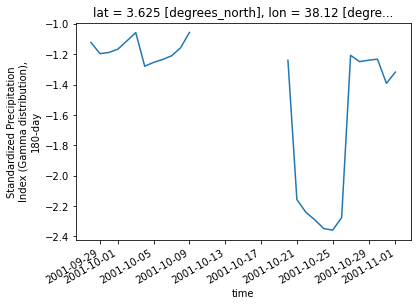

In [39]:
new_xr.where(new_xr.masked==0).sel(lat= 3.625, lon=38.125, method='nearest')['spi_gamma_180'].plot() #.where(null_mask['spi_gamma_180']!=0)
plt.show()


In [19]:
dir = r'C:\Users\Riccardo\Desktop\PhD_docs\Drought_prediction\Project\Indices_analysis\data\events'

import pandas as pd
import glob
import os

# setting the path for joining multiple files
files = os.path.join(dir, "*.csv")

# list of merged files returned
files = glob.glob(files)

print("Resultant CSV after joining all CSV files at a particular location...");

# joining files with concat and read_csv
df = pd.concat(map(pd.read_csv, files), ignore_index=True)

Resultant CSV after joining all CSV files at a particular location...


In [24]:
df = pd.read_csv(r'C:\Users\Riccardo\Desktop\PhD_docs\Drought_prediction\Project\Indices_analysis\data\events\merged.csv', index_col=0)

In [25]:
df

,lat,lon,time,severity,duration,intensity,year,month,product,latency
0,-4.625000,39.375000,2004-06-30,217.764604,128.0,1.701286,2004,6,CHIRPS,spi_gamma_180
1,-4.625000,39.375000,2005-05-01,34.122544,21.0,1.624883,2005,5,CHIRPS,spi_gamma_180
2,-4.625000,39.375000,2006-01-07,10.463078,10.0,1.046308,2006,1,CHIRPS,spi_gamma_180
3,-4.625000,39.375000,2006-01-20,4.084826,4.0,1.021206,2006,1,CHIRPS,spi_gamma_180
4,-4.625000,39.375000,2006-01-27,2.040761,2.0,1.020381,2006,1,CHIRPS,spi_gamma_180
...,...,...,...,...,...,...,...,...,...,...
1845229,14.700002,38.100002,2013-09-07,1.010643,1.0,1.010643,2013,9,IMERG,spi_gamma_90
1845230,14.700002,38.100002,2013-09-21,15.223160,14.0,1.087369,2013,9,IMERG,spi_gamma_90
1845231,14.700002,38.100002,2015-02-16,2.277714,2.0,1.138857,2015,2,IMERG,spi_gamma_90
1845232,14.700002,38.100002,2015-08-02,25.983160,22.0,1.181053,2015,8,IMERG,spi_gamma_90


In [27]:
from shapely.prepared import prep

shapefile_path = os.path.join('..', config['SHAPE']['africa'])
df['time'] = pd.to_datetime(df['time'])
#### Chose subset of countries
#countries = ['Ethiopia','Somalia','Kenya']
gdf = gpd.read_file(shapefile_path)
year = 2008
country = ['Ethiopia']
product = 'CHIRPS'
spi= 180

def plot_year_drought(df,  product, spi, country, year=None):
    latency = 'spi_gamma_{}'.format(spi)
    subset = gdf[gdf.ADM0_NAME.isin(country)]
    
    if year== None:
        subset_df = df.loc[(df['product'] == product)  & (df['latency'] == latency)]
    #elif country==None:
        #subset_df = df.loc[(df['product'] == product)  & (df['latency'] == latency)]
    else:
        subset_df = df.loc[(df.year==year) & (df['product'] == product)  & (df['latency'] == latency)]

    geo_df = gpd.GeoDataFrame(subset_df, geometry=gpd.points_from_xy(subset_df.lon, subset_df.lat))
    grid_polygon_prep = prep(subset.geometry.iloc[0])
    geo_df_filtered = geo_df.loc[geo_df.geometry.apply(lambda p: grid_polygon_prep.contains(p))]

    temp_xr = geo_df_filtered.set_index(['lat','lon','time']).to_xarray()

    temp_xr['duration'].mean(['time']).plot(cmap='seismic',  vmin=0, vmax=30)
    plt.title('Mean drought duration in the sample')
    plt.show()
    temp_xr['severity'].mean(['time']).plot(cmap='seismic', vmin=0, vmax=50)
    plt.title('Mean drought severity in the sample')
    plt.show()
    temp_xr['intensity'].mean(['time']).plot(cmap='seismic', vmin=0, vmax=3)
    plt.title('Mean drought intensity in the sample')
    plt.show()

def table_year_drought(df,  product, spi, country, year=None):
    latency = 'spi_gamma_{}'.format(spi)
    subset = gdf[gdf.ADM0_NAME.isin([country])]
    
    if year== None:
        subset_df = df.loc[(df['product'] == product)  & (df['latency'] == latency)]
    else:
        subset_df = df.loc[(df.year==year) & (df['product'] == product)  & (df['latency'] == latency)]

    geo_df = gpd.GeoDataFrame(subset_df, geometry=gpd.points_from_xy(subset_df.lon, subset_df.lat))
    grid_polygon_prep = prep(subset.geometry.iloc[0])
    geo_df_filtered = geo_df.loc[geo_df.geometry.apply(lambda p: grid_polygon_prep.contains(p))]
    temp_df = geo_df_filtered.groupby(['year']).mean()[['severity','duration','intensity']].reset_index()
    temp_df['country'] = country
    temp_df['prorduct'] = product
    temp_df['latency'] = latency
    return temp_df

In [169]:
final_df = pd.DataFrame()

for cntr in ['Ethiopia','Somalia','Kenya']:
    for prod in ['CHIRPS', 'IMERG','ERA5','GPCC']:
        for late in [30, 60, 90, 180]:
            res_df = table_year_drought(df, prod, late, cntr)
            final_df = final_df.append(res_df, ignore_index=True)

C:\Users\Riccardo\AppData\Local\Temp\ipykernel_17340\3893254605.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = final_df.append(res_df, ignore_index=True)
C:\Users\Riccardo\AppData\Local\Temp\ipykernel_17340\3893254605.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = final_df.append(res_df, ignore_index=True)
C:\Users\Riccardo\AppData\Local\Temp\ipykernel_17340\3893254605.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = final_df.append(res_df, ignore_index=True)
C:\Users\Riccardo\AppData\Local\Temp\ipykernel_17340\3893254605.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = final_d

In [171]:
final_df.to_csv(r'C:\Users\Riccardo\Desktop\PhD_docs\Drought_prediction\Project\Indices_analysis\data\run_theory_prods.csv')

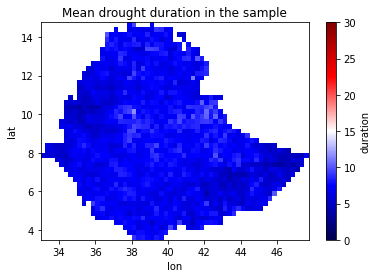

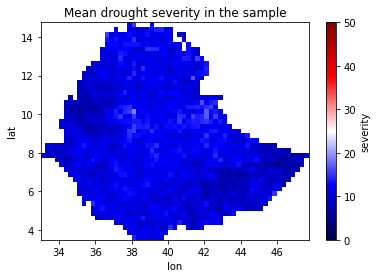

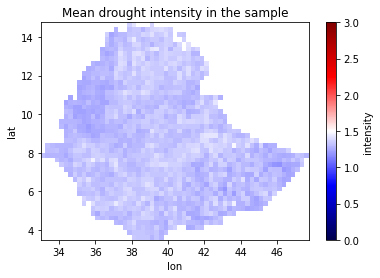

In [29]:
import matplotlib.pyplot as plt
plot_year_drought(df,  "CHIRPS", 30, country, year=None)

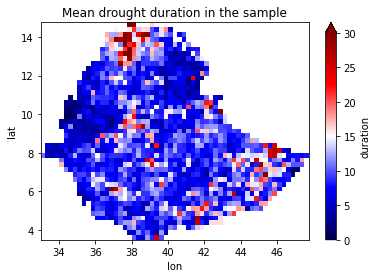

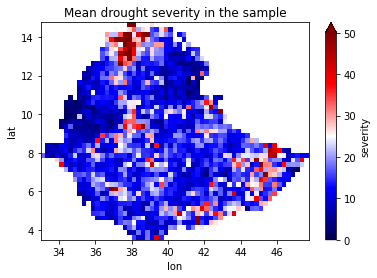

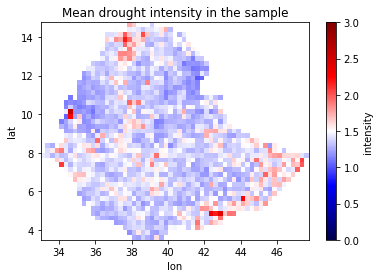

Conditions in year 2004


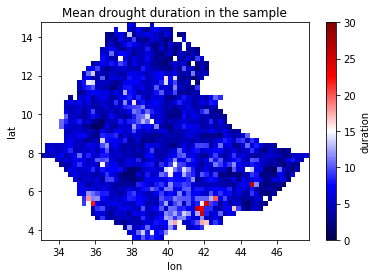

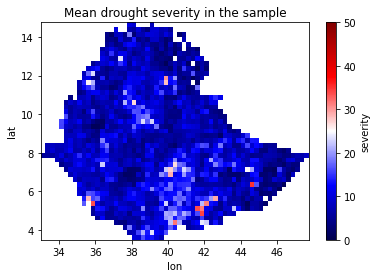

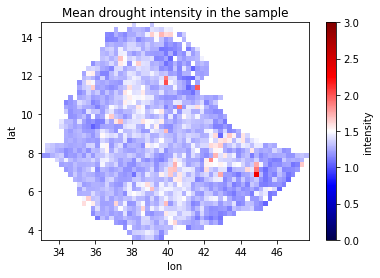

Conditions in year 2005


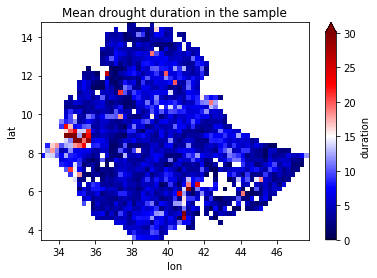

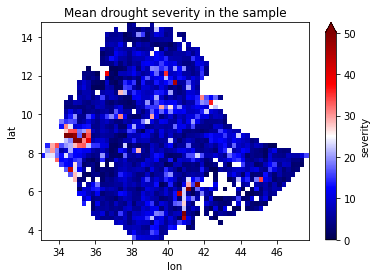

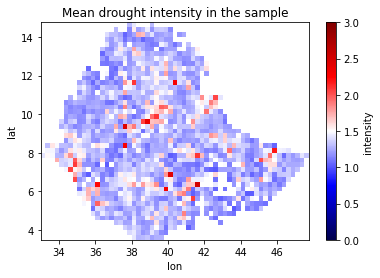

Conditions in year 2006


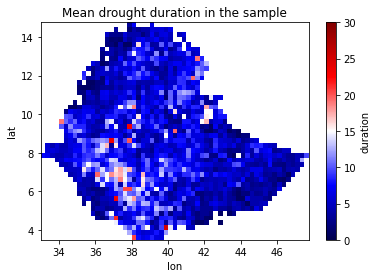

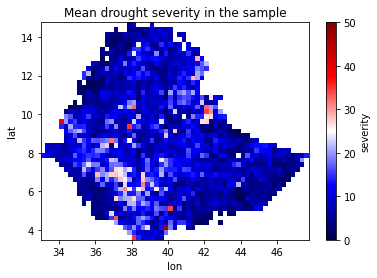

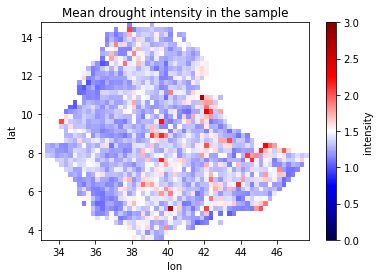

Conditions in year 2007


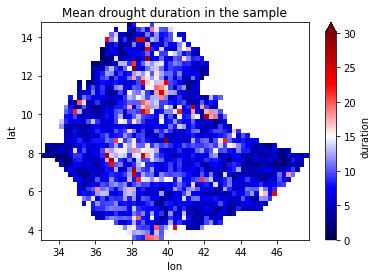

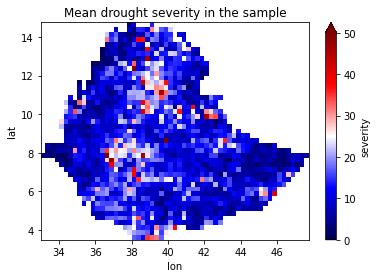

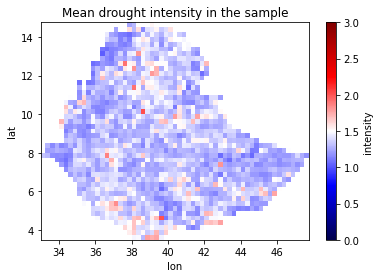

Conditions in year 2008


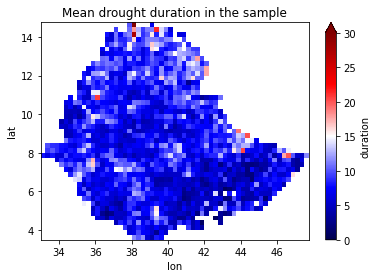

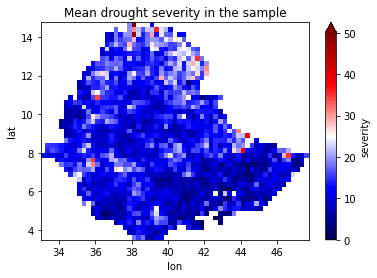

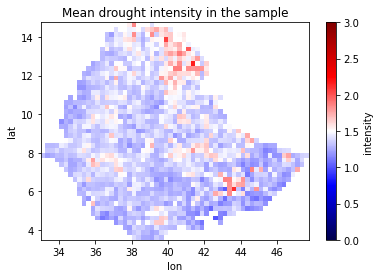

Conditions in year 2009


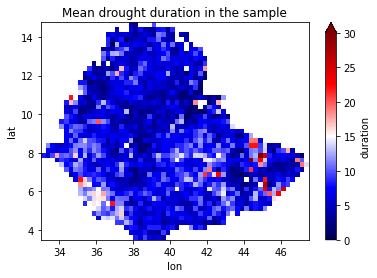

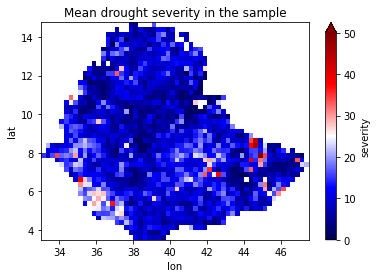

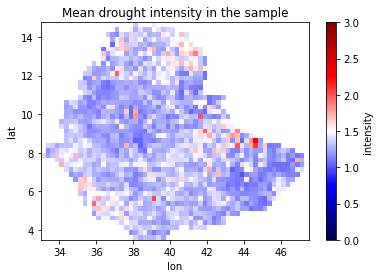

Conditions in year 2010


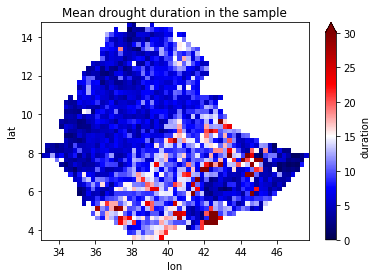

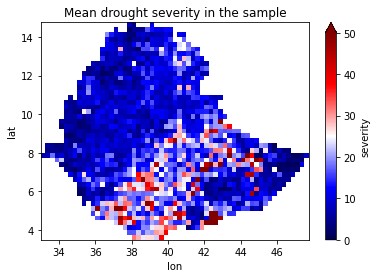

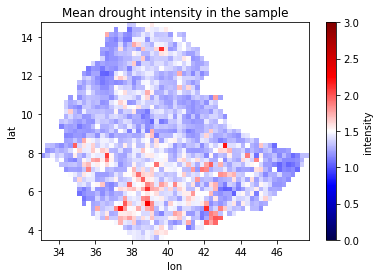

Conditions in year 2011


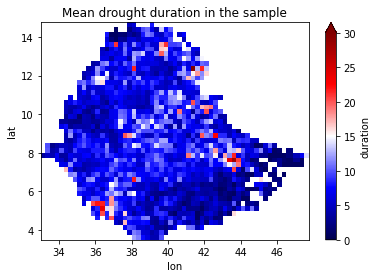

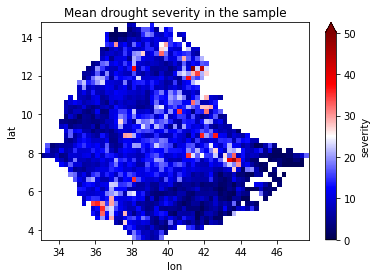

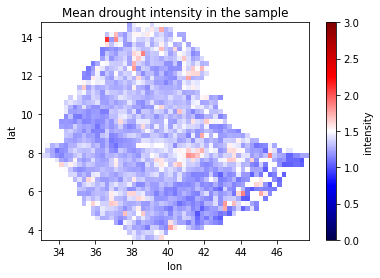

Conditions in year 2012


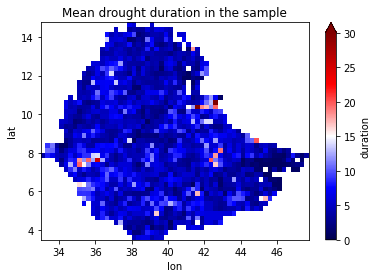

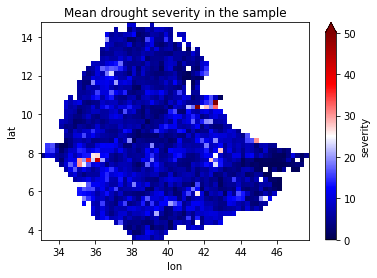

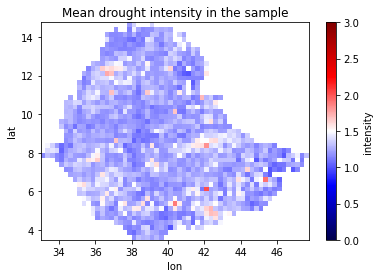

Conditions in year 2013


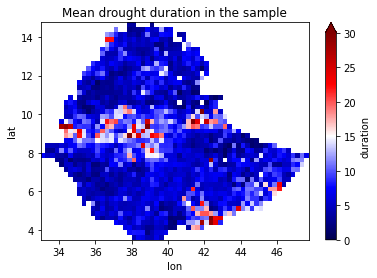

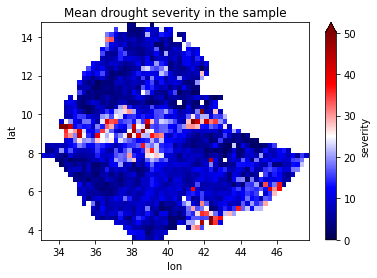

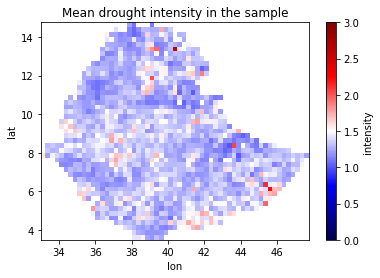

Conditions in year 2014


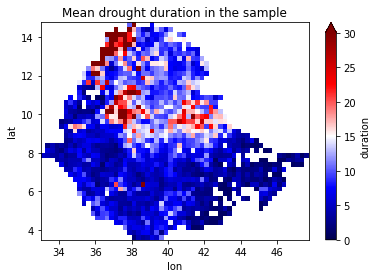

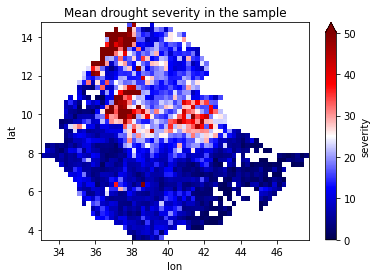

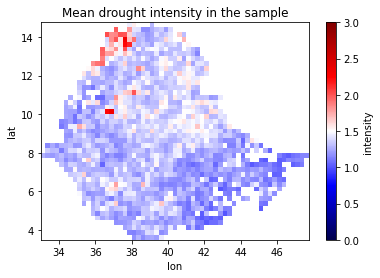

Conditions in year 2015


In [156]:
for year in range(2004,2016):
    plot_year_drought(df,  "CHIRPS", 30, country, year=year)
    print('Conditions in year', year)

#### NDVI and VCI

In [8]:
import xarray as xr
base_dir = r'D:\shareVM\MSG\msg_data\batch_2\processed\*.nc'
    #print([f for f in os.listdir(base_dir) if f.endswith('.nc')])
xr_df = xr.open_mfdataset(base_dir, chunks={"lat": -1, "lon": -1, "time": 12})


In [48]:
def compute_radiance(xr_df):
    satellite = xr_df.attrs['EPCT_product_name'][:4]
    if satellite == 'MSG2':
        xr_df['channel_1'] = xr_df['channel_1']/65.2065
        xr_df['channel_2'] = xr_df['channel_2']/73.0127
        
    elif satellite == 'MSG1':
        xr_df['channel_1'] = xr_df['channel_1']/65.2296 
        xr_df['channel_2'] = xr_df['channel_2']/73.1869
    
    elif satellite == 'MSG3':
        xr_df['channel_1'] = xr_df['channel_1']/65.5148 
        xr_df['channel_2'] = xr_df['channel_2']/73.1807
        
    elif satellite == 'MSG4':
        xr_df['channel_1'] = xr_df['channel_1']/65.2656
        xr_df['channel_2'] = xr_df['channel_2']/73.1692
    
    else:
        print('This product doesn\'t contain MSG1, MSG2, MSG3, MSG4 Seviri')
    
    return xr_df

def correct_radiance(xr_df):
    satellite = xr_df.attrs['EPCT_product_name'][:4]
    if satellite == 'MSG2':
        xr_df['channel_1'] = xr_df['channel_1']*65.2065
        xr_df['channel_2'] = xr_df['channel_2']*73.0127
        
    elif satellite == 'MSG1':
        xr_df['channel_1'] = xr_df['channel_1']*65.2296 
        xr_df['channel_2'] = xr_df['channel_2']*73.1869
    
    elif satellite == 'MSG3':
        xr_df['channel_1'] = xr_df['channel_1']*65.5148 
        xr_df['channel_2'] = xr_df['channel_2']*73.1807
        
    elif satellite == 'MSG4':
        xr_df['channel_1'] = xr_df['channel_1']*65.2656
        xr_df['channel_2'] = xr_df['channel_2']*73.1692
    
    else:
        print('This product doesn\'t contain MSG1, MSG2, MSG3, MSG4 Seviri')
    
    return xr_df

#xr_df = correct_radiance(xr_df)
xr_df = xr_df.assign(ndvi=(xr_df['channel_3'] - xr_df['channel_2']) / (xr_df['channel_3'] + xr_df['channel_2']))

In [81]:
print(xr_df.attrs)

{'Conventions': 'CF-1.5', 'ch01_cal': '-1.173683395609e+00 2.301339991391e-02', 'ch02_cal': '-1.520390091464e+00 2.981157042086e-02', 'ch03_cal': '-1.205720711499e+00 2.364158257842e-02', 'ch04_cal': '-1.865920103496e-01 3.658666869601e-03', 'ch05_cal': '-4.242236706827e-01 8.318111189856e-03', 'ch06_cal': '-1.969720376950e+00 3.862196817550e-02', 'ch07_cal': '-6.463960252982e+00 1.267443186859e-01', 'ch08_cal': '-5.302006445576e+00 1.039609106976e-01', 'ch09_cal': '-1.045681948659e+01 2.050356762077e-01', 'ch10_cal': '-1.133786848073e+01 2.223111466809e-01', 'ch11_cal': '-8.037951740768e+00 1.576068968778e-01', 'date_time': '20050101/12:12', 'origin': '1 1', 'radiometric_parameters_format': 'offset slope', 'EPCT_geospatial_lat_max': '81.2597442', 'EPCT_geospatial_lat_min': '-81.2596919', 'EPCT_geospatial_lon_max': '81.2597442', 'EPCT_geospatial_lon_min': '-81.2596919', 'EPCT_orbit': 'N/A', 'EPCT_processing_level': '1.5', 'EPCT_product_name': 'MSG1-SEVI-MSG15-0201-NA-20050101121243.120

(array([1.35645500e+06, 1.80186600e+06, 1.12383120e+07, 1.12556384e+08,
        1.38208063e+08, 1.15162214e+08, 4.30609600e+07, 5.05294000e+06,
        2.07256000e+05, 2.73300000e+03]),
 array([-1.2057207,  0.2959513,  1.7976233,  3.2992952,  4.800967 ,
         6.302639 ,  7.8043113,  9.305983 , 10.807655 , 12.309327 ,
        13.810999 ], dtype=float32),
 <BarContainer object of 10 artists>)

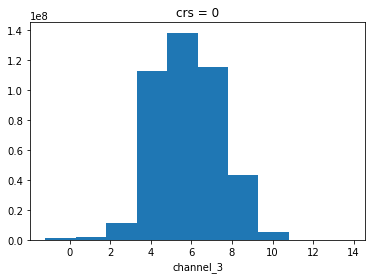

In [78]:
xr_df['channel_3'].plot()

(array([4.28647172e+08, 9.00000000e+00, 1.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.00000000e+00]),
 array([ -90.717155,   23.274958,  137.26707 ,  251.25919 ,  365.2513  ,
         479.2434  ,  593.23553 ,  707.22766 ,  821.2197  ,  935.21185 ,
        1049.204   ], dtype=float32),
 <BarContainer object of 10 artists>)

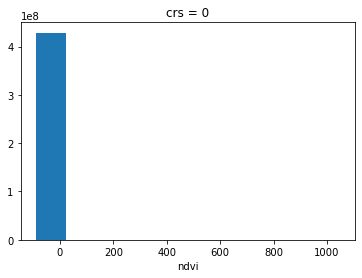

In [79]:
xr_df['ndvi'].plot()

In [9]:
config = load_config(CONFIG_PATH)
shapefile_path = os.path.join('..', config['SHAPE']['africa'])
#### Chose subset of countries
gdf = gpd.read_file(shapefile_path)
subset = gdf[gdf.ADM0_NAME.isin(['Ethiopia'])]
ds = cut_file(xr_df, subset)
#ds = ds.load()

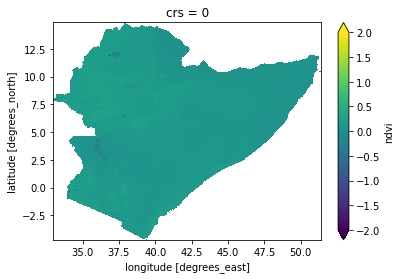

In [23]:
xr_df['ndvi'].mean(['time']).plot(vmin=-2, vmax=2)

In [10]:
gb = ds['ndvi'].groupby('time.dayofyear')
clim = gb.mean(dim='time')
std_clim = gb.std(dim='time')


In [11]:
res = xr.apply_ufunc(lambda x, m, s: (x - m) / s, gb, clim, std_clim, dask='allowed')

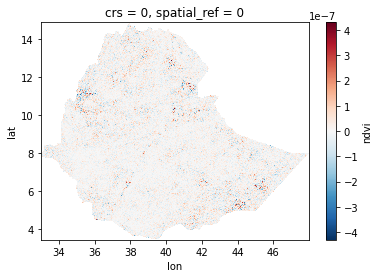

In [41]:
res.mean(['time']).plot()

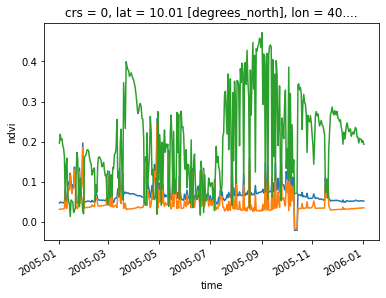

In [16]:
xr_df['channel_2'].sel(time=slice('2005-01-01', '2006-01-01')).sel(lon=40, lat = 10, method='nearest').plot()
xr_df['channel_1'].sel(time=slice('2005-01-01', '2006-01-01')).sel(lon=40, lat = 10, method='nearest').plot()
xr_df['ndvi'].sel(time=slice('2005-01-01', '2006-01-01')).sel(lon=40, lat = 10, method='nearest').plot()

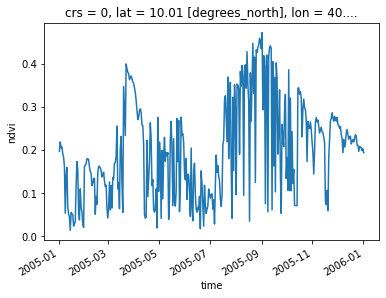

In [17]:
xr_df['ndvi'].sel(time=slice('2005-01-01', '2006-01-01')).sel(lon=40, lat = 10, method='nearest').plot()

c:\Users\Riccardo\anaconda3\envs\gis2_py39\lib\site-packages\dask\array\numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


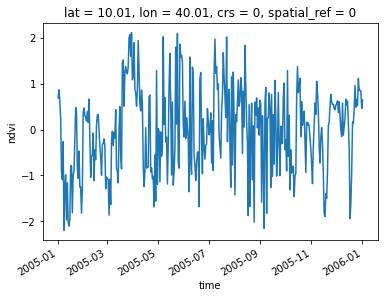

In [12]:
res.sel(time=slice('2005-01-01', '2006-01-01')).sel(lon=40, lat = 10, method='nearest').plot()

In [59]:

file ='MSG1-SEVI-MSG15-0100-NA-20050725121242.236000000Z-NA.nat'

In [61]:

from satpy import DataQuery
from satpy import Scene
import xarray as xr
from satpy.dataset import combine_metadata
import matplotlib.pyplot as plt
from glob import glob

my_channel_id = DataQuery(name=['VIS006'], calibration='reflectance')
my_channel_id_2 = DataQuery(name=['VIS008'], calibration='reflectance')

scn.load([my_channel_id, my_channel_id_2])

'D:\\shareVM\\MSG\\MSG_nat\\batch_2\\MSG1-SEVI-MSG15-0100-NA-20050725121242.236000000Z-NA.nat'

In [73]:
from satpy.scene import Scene
from satpy.resample import get_area_def
from satpy import find_files_and_readers
from datetime import datetime
import glob
import warnings

base_dir = r'D:\shareVM\MSG\MSG_nat\batch_2\MSG_data\*.nat'
filenames = glob.glob(base_dir)
scn = Scene(reader='seviri_l1b_native', filenames=filenames,
        reader_kwargs={'calib_mode': 'GSICS'})

scn.load(['VIS006', 'VIS008'])
scn["ndvi"] = (scn['VIS008'] - scn['VIS006']) / (scn['VIS008'] + scn['VIS006'])
#scn.show("ndvi")
scene_llbox = scn.crop(ll_bbox=(32.9, 3.2, 48, 15))

c:\Users\Riccardo\anaconda3\envs\gis_py39\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
c:\Users\Riccardo\anaconda3\envs\gis_py39\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)


NotImplementedError: 

In [25]:
#std_ndvi = (gb - clim)/std_clim

c:\Users\Riccardo\anaconda3\envs\gis_py39\lib\site-packages\dask\array\core.py:4601: PerformanceWarning: Increasing number of chunks by factor of 366
  result = blockwise(


In [21]:
res_xr = xr.apply_ufunc(lambda x, m, s: (x - m) / s, gb, clim, std_clim, dask='allowed')

c:\Users\Riccardo\anaconda3\envs\gis_py39\lib\site-packages\dask\array\numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
c:\Users\Riccardo\anaconda3\envs\gis_py39\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


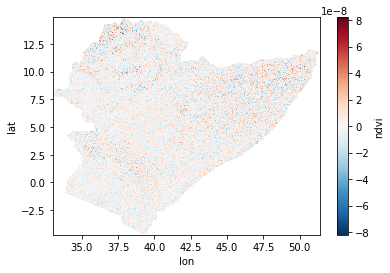

In [22]:
res_xr.mean(['time']).plot()

## Regridded products

In [78]:
def date_compat_check(xr_df, target_df):
    min_target = target_df['time'].min().values
    max_target = target_df['time'].max().values
    min_xr = xr_df['time'].min().values
    max_xr = xr_df['time'].max().values

    if (min_target < min_xr) & (max_target>max_xr):
        return target_df.sel(time=slice(min_xr, max_xr))
    elif (min_target > min_xr) & (max_target>max_xr):
        return target_df.sel(time=slice(min_target, max_xr))
    elif (min_target < min_xr) & (max_target<max_xr):
        return target_df.sel(time=slice(min_xr, max_target))
    else:
        print('The target dataset has inferior dimensions than the origin')
        return target_df

def pod_index(ds, ds_t):
    A_var = ds_t['dry'] == ds['dry']
    C_var = (ds['dry'] == 1) & (A_var == False)
    return A_var/(A_var+C_var)

def far_index(ds, ds_t):
    A_var = ds_t['dry'] == ds['dry']
    B_var = (ds_t['dry'] == 1) & (A_var == False)
    return B_var/(B_var+A_var)

def accuracy_index(ds, ds_t):
    A_var = ds_t['dry'] == ds['dry']
    B_var = (ds_t['dry'] == 1) & (A_var == False)
    C_var = (ds['dry'] == 1) & (A_var == False)
    return 2*A_var/(2*A_var+B_var+C_var)

def compute_indixes(ds, ds_t):
    far = far_index(ds, ds_t)
    pod = pod_index(ds, ds_t)
    accuracy = accuracy_index(ds, ds_t)
    return far, pod, accuracy

def plot_indices(spi_base, spi_target, far, pod, accuracy):
    pod.mean(['time']).plot()
    plt.title('Compute mean POD between {t} and {b}'.format(t= spi_base.product[:-1], b= spi_target.product[:-1]))
    plt.show()
    far.mean(['time']).plot()
    plt.title('Compute mean FAR between {t} and {b}'.format(t= spi_base.product[:-1], b= spi_target.product[:-1]))
    plt.show()
    accuracy.mean(['time']).plot()
    plt.title('Compute mean accuracy between {t} and {b}'.format(t= spi_base.product[:-1], b= spi_target.product[:-1]))
    plt.show()

def precp_indices_pipeline(target_path, base_path, target_new, plot=True):
    ### initialize an spi object for the regridded dataset
    spi_target =  spiObject()
    spi_target.xr = xr.open_dataset(target_path)
    spi_ = spi_target.calculate_points_xr()

    ### initialize a new object for the target dataset
    spi_base = spiObject(base_path)
    spi_base.xr =  target_new
    gpcc_ = spi_base.calculate_points_xr()

    ###subset the image
    ds = cut_file(gpcc_, subset)
    ds_t = cut_file(spi_, subset)

    ### compute the indices
    far, pod, accuracy = compute_indixes(ds, ds_t)
    if plot == True:
        plot_indices(spi_base, spi_target, far, pod, accuracy)
    return far, pod, accuracy

In [6]:
CONFIG_PATH = r"../config.yaml"
config = load_config(CONFIG_PATH)
    
var = 'spi_gamma_180'
product_dir_target = config['SPI']['GPCC']['path']
product_directories = [config['SPI']['IMERG']['path'], config['SPI']['CHIRPS']['path'],  config['SPI']['ERA5']['path']]

file_target = [f for f in os.listdir(product_dir_target) if f.endswith('.nc') and var in f]
target_xr = xr.open_dataset(os.path.join(product_dir_target,file_target[0]))


target_dir = os.path.join(product_directories[0], 'regridded')
file  = [f for f in os.listdir(target_dir) if f.endswith('.nc') and var in f]
xr_df = xr.open_dataset(os.path.join(target_dir,file[0]))
xr_df = xr_df.drop_dims(['lat','lon']).rename({'x':'lon', 'y':'lat'})
xr_df = xr_df.rename({'regrid_spi_gamma_180': 'spi_gamma_180'})
target_new = date_compat_check(xr_df, target_xr)
final_xr = xr_df.where(target_new.notnull())
#xr_df.assign(masked_series = masked_data)
#final_xr.to_netcdf(target_dir, 'matched', file[0])
    

Computed new variables for xarray
Computed new variables for xarray


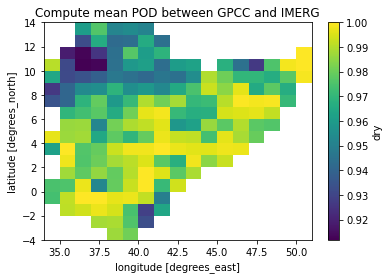

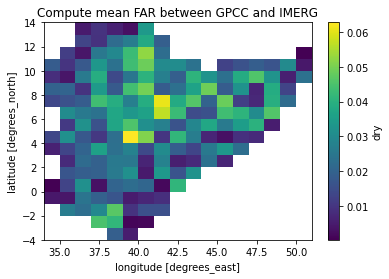

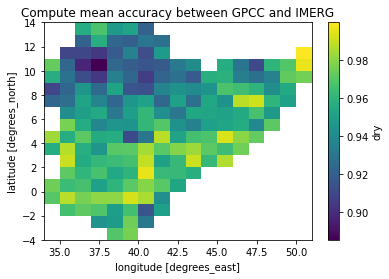

In [79]:
from SPI_wet_dry import spiObject
import matplotlib.pyplot as plt


countries = ['Ethiopia','Somalia','Kenya']
shapefile_path = os.path.join('..',config['SHAPE']['africa'])
#### Chose subset of countries
gdf = gpd.read_file(shapefile_path)
subset = gdf[gdf.ADM0_NAME.isin(countries)]


path = r'D:\shareVM\IMERG\daily\SPI\regridded\matched'
target_path = os.path.join(path, file[0])

base_path = os.path.join(product_dir_target,file_target[0])



In [2]:
type(ds)

xarray.core.dataset.Dataset

In [11]:
from p_drought_indices.functions.function_clns import load_config
from p_drought_indices.ancillary_vars.FAO_HWSD import get_soil_vars
import xarray as xr
ds = xr.open_dataset(r'D:\shareVM\MSG\msg_data\processed\vci_1D.nc')
config_path = r'../config.yaml'

countries =['Ethiopia','Kenya','Somalia']
ds_soil = get_soil_vars(CONFIG_PATH= config_path, countries=countries, xr_df = ds, invert=False)

Using provided xarray dataframe for querying FAO HWSD


100%|██████████| 2160/2160 [00:22<00:00, 95.60it/s] 


Starting adding slopes...


100%|██████████| 2160/2160 [00:08<00:00, 268.27it/s] 


Starting adding land covers...


100%|██████████| 2160/2160 [00:14<00:00, 144.40it/s]


Starting adding soil covers...


100%|██████████| 2160/2160 [00:28<00:00, 74.71it/s] 


In [22]:
from p_drought_indices.functions.function_clns import subsetting_pipeline

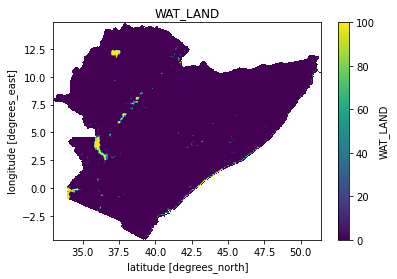

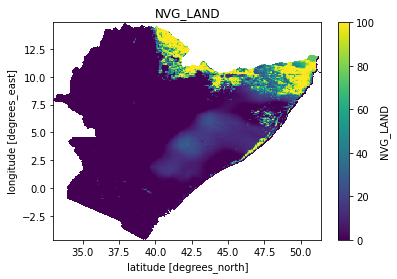

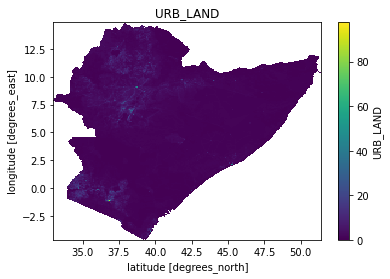

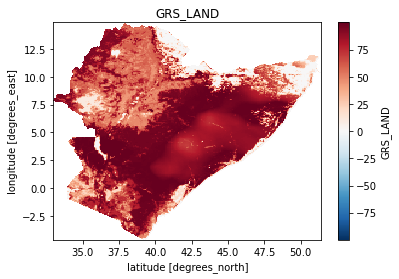

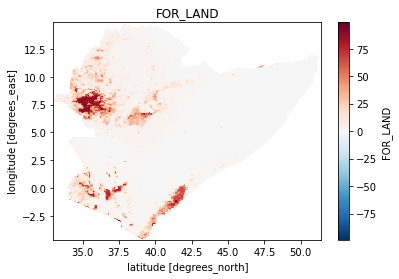

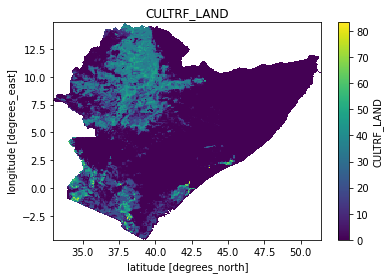

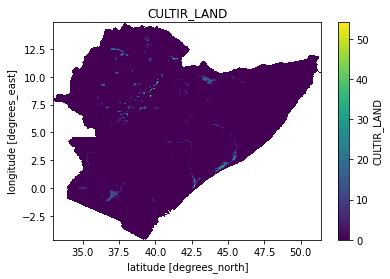

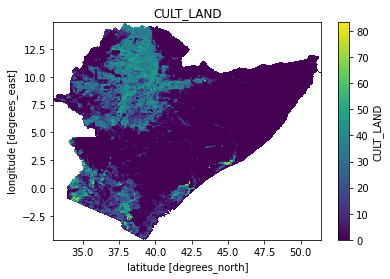

In [24]:
import matplotlib.pyplot as plt
for var in [i for i in list(ds_soil.data_vars) if "LAND" in i]:
    subsetting_pipeline(xr_df = ds_soil[var].transpose('lat','lon'), CONFIG_PATH=config_path, countries=countries).plot()
    plt.title(var)
    plt.show()